# CS579: Lecture 10  

**Sentiment Analysis**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

*Warning: Live Twitter data is used below, some or all of which may be offensive.*

**sen·ti·ment**

1. a view of or attitude toward a situation or event; an opinion.
2. a feeling or emotion.


**sen·ti·ment &nbsp; a·nal·y·sis ** 

1. classification of documents/messages by sentiment

# Examples

![tmnt.png](tmnt.png)

![ufo](ufo.png)

![ufo-review](ufo-review.png)

![mcds](mcds.png)

![rauner](rauner.png)
![quinn](quinn.png)

## Why is this hard?


# Two Approaches

- Lexicons (word lists)

- Machine learning

# Lexicons

- List of terms with positive/negative/neutral sentiment

- E.g., AFINN: http://neuro.imm.dtu.dk/wiki/AFINN


In [1]:
# Download the AFINN lexicon, unzip, and read the latest word list in AFINN-111.txt
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(BytesIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0].decode("utf-8")] = int(parts[1])

print('read %d AFINN terms.\nE.g.: %s' % (len(afinn), 
                                          str(list(afinn.items())[:10])))

read 2462 AFINN terms.
E.g.: [('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)]


In [2]:
len(afinn)

2462

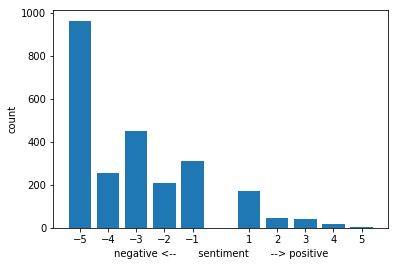

In [26]:
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel('negative <--       sentiment       --> positive')
plt.ylabel('count')
plt.show()

In [27]:
# How do we score a document?
def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print('\t%s=%d' % (t, afinn[t]))
            total += afinn[t]
    return total
    
doc = "i don't know if this is a scam or if mine was broken".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	scam=-2
	broken=-1
AFINN:  -3.0


In [28]:
# What if mixed sentiment?
doc = "it has a hokey plot that is both too good and bad".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	good=3
	bad=-3
AFINN:  0.0


In [29]:
# Distinguish neutral from pos/neg.
# Return two scores per document.
def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print('\t%s=%d' % (t, afinn[t]))
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	good=3
	bad=-3
AFINN: (3, 3)


In [30]:
doc = "the plot is not bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	bad=-3
AFINN: (0, 3)


In [31]:
import configparser
from TwitterAPI import TwitterAPI

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets',
                         {'q': 'mcdonalds', 'count': 100}):
    tweets.append(r)

In [32]:
print('read %d mcdonalds tweets' % len(tweets))

read 100 mcdonalds tweets


In [33]:
# Tokenize tweets
import re

# \w = [a-zA-Z0-9_]
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print('tokenized, e.g., \n%s\nto\n%s' % 
      (tweets[10]['text'], tokens[10]))
#tweets[50]['user']['name']
# tweets[50]['user']['screen_name']

tokenized, e.g., 
RT @FemaleTexts: dont look at my twitter to see how my relationship is going I could tweet “I’m so done” n it’ll be cos my mum didn’t get m…
to
['rt', 'femaletexts', 'dont', 'look', 'at', 'my', 'twitter', 'to', 'see', 'how', 'my', 'relationship', 'is', 'going', 'i', 'could', 'tweet', 'i', 'm', 'so', 'done', 'n', 'it', 'll', 'be', 'cos', 'my', 'mum', 'didn', 't', 'get', 'm']


In [34]:
tokenize("Hi there how are you? Don't you ... #awesome @awesome http://www.good.com")

['hi',
 'there',
 'how',
 'are',
 'you',
 'don',
 't',
 'you',
 'awesome',
 'awesome',
 'http',
 'www',
 'good',
 'com']

In [35]:
positives = []
negatives = []
for token_list, tweet in zip(tokens, tweets):
    pos, neg = afinn_sentiment2(token_list, afinn)
    if pos > neg:
        positives.append((tweet['text'], pos, neg))
    elif neg > pos:
        negatives.append((tweet['text'], pos, neg))

In [37]:
len(negatives)

14

In [38]:
# Print top positives:
for tweet, pos, neg in sorted(positives,
                              key=lambda x: x[1],
                              reverse=True):
    print(pos, neg, tweet)

6 1 @brad_schwartz We love hearing that you're a fan! Stop by for lunch again soon.
6 3 i love when people told me that working at mcdonalds, you will start to hate the food. me, i started craving it more  LOL
5 0 Watched @thefounderfilm and won’t be eating at @McDonalds anymore. Nothing like taking someone’s work and taking the credit! @McDonaldsCorp
5 0 @McDonalds thank you for inspiring me
5 0 @Ijooheons We hope you enjoy a tasty Big Mac soon!
4 0 @McDonalds why won't you chop up my apple pie and put it in my McFlurry for me. Apple pie and ice cream!! I dont want them seperately 😣
3 0 RT @TinyKitchenVids: Tiny McDonalds Happy Meal. 🍔🍟 https://t.co/aikdWYWfkR
3 0 @LaurenEnchanted We love your dedication to deliciousness!
3 0 @TheOGDib We love the enthusiasm! Can't wait to see you.
3 0 @McDonalds ""best kosher food =Jewish meat cooked in an oven+red wine " https://t.co/I2U9QfGPt5
3 0 I remember when McDonalds nuggets box came with the little thing to put the sauce in 😪 good times
2 0 

In [41]:
afinn_sentiment2(tokenize('Watched @thefounderfilm and won’t be eating at @McDonalds anymore. Nothing like taking someone’s work and taking the credit! @McDonaldsCorp'),
                 afinn, verbose=True)

	won=3
	like=2


(5, 0)

In [42]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print(pos, neg, tweet)

0 5 RT @callboyyy: Mama nein ich hab die 10 euro nicht für drogen ausgegeben ich war in Mcdonalds mit meinen Freunden
0 5 RT @OceanGrownTREEZ: This Mcdonalds serve real niggas only. https://t.co/v8zxZIT3WP
0 3 I've been on McDonalds five times in one week and I have no problem with that
0 3 Харесах видеоклип в @YouTube – https://t.co/RqC0PBn0Y7 „McDONALDS BREAKFAST vs HOMEMADE - So bad we take the food
0 2 Only at Williamston's McDonalds a lady would call the manager out to the drive thru ordering machine to complain with 10 cars behind her🤗
0 2 RT @_Karlisimmons: I'll just starve before eating McDonalds
0 2 passou uma propaganda do @McDonalds_BR  ali agora tem nem um gordo absurdo isso, me chamem
0 1 Fue a comprar comida rápida y como no lo atendieron rápido amenazó con matar al vendedor https://t.co/glz3PmIPNB
0 1 o jisung me levaria no mcdonalds
0 1 McDonalds no se da cuenta de que si su servicio a domicilio llegase a mi resi, solo conmigo ya estarían el triple de forrados
0 1 ong m

In [45]:
afinn_sentiment2(tokenize("Fue a comprar comida rápida y como no lo atendieron rápido amenazó con matar al vendedor"),
                 afinn, verbose=True)

	no=-1


(0, 1)

# Sentiment Trends?
![politico](politico.png)

What can go wrong?

<br><br><br><br>

In [46]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(),
                       key=lambda x:x[1],
                       reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print('%s count=%d sentiment=%d' % (token, count, afinn[token]))
        i += 1
        if i > 10:
            break

no count=5 sentiment=-1
love count=4 sentiment=3
big count=2 sentiment=1
won count=2 sentiment=3
like count=2 sentiment=2
hope count=2 sentiment=2
dump count=2 sentiment=-1
yes count=1 sentiment=1
happy count=1 sentiment=3
complain count=1 sentiment=-2
thank count=1 sentiment=2


In [50]:
[t for t in tokens if 'happy' in t]

[['rt',
  'tinykitchenvids',
  'tiny',
  'mcdonalds',
  'happy',
  'meal',
  'https',
  't',
  'co',
  'aikdwywfkr']]

# Part of speech?

> *I hate McDonlads.*  
> *Hate speech is wrong.*

> *Rauner is lying.*  
> *Lying in bed with the flu.*

Noun/verb/adjective form of term may have different sentiment.

# WordNet

- A database of words and their relations
- http://wordnet.princeton.edu/
- Statistics: http://wordnet.princeton.edu/wordnet/man/wnstats.7WN.html

# WordNet

- **Synset:**
  - A list of synonyms
  - E.g. [dog](http://wordnetweb.princeton.edu/perl/webwn?s=dog&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=11000000000000000000001000000000)
- **Hypernym:**
  - Y is a Hypernym of X if every X is a kind of Y
    - **canine** is a hypernym of **dog**
- **Hyponym:**
  - Y is a Hyponym of X if every Y is a kind of X
    - **dog** is a hyponym of **canine**
    
<br><br><br>

<img src="https://upload.wikimedia.org/wikipedia/en/1/1f/Hyponymsandhypernyms.jpg">

# SentiWordNet

http://sentiwordnet.isti.cnr.it/

![senti](senti.png)

[source](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf)

In [58]:
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
# must run nltk.download('sentiwordnet')
happy = list(swn.senti_synsets('happy', 'a'))[0]

print('happy(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (happy.neg_score(), happy.pos_score(), happy.obj_score()))

happy(a): negative_score=0.00 positive_score=0.88 objective_score=0.12


In [59]:
hate = list(swn.senti_synsets('hate', 'n'))[0]

print('hate(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(n): negative_score=0.38 positive_score=0.12 objective_score=0.50


In [60]:
hate = list(swn.senti_synsets('hate', 'v'))[0]

print('hate(v): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(v): negative_score=0.75 positive_score=0.00 objective_score=0.25


In [65]:
good = list(swn.senti_synsets('good', 'a'))[1]
print('good(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (good.neg_score(), good.pos_score(), good.obj_score()))

good(a): negative_score=0.00 positive_score=0.00 objective_score=1.00
